In [1]:
import pandas as pd
from collections import Counter, defaultdict
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import umap
%matplotlib inline
datafile = 'dataset2.count.txt'
df = pd.read_csv(datafile, sep='\t')

In [2]:
df = df.set_index('Gene.Symbol')
cells = list(df.columns.values)

In [3]:
mat = np.array(df)
per_cell_sum = mat.sum(axis=1)
per_gene_sum = mat.sum(axis=0)
low_expr_thr = 100
high_expr_thr = 1000000
mat = mat[:, (per_gene_sum>=low_expr_thr) & (per_gene_sum<=high_expr_thr)]
mean_exp = mat.mean(axis=0)
std_exp = np.sqrt(mat.std(axis=0))
CV = std_exp/mean_exp
mat = mat[:, CV >= 1.5]
cells_expression = mat.sum(axis=1)
mat = mat[cells_expression>=100, :]
mat = np.log(mat+1)
#df = pd.DataFrame(mat,index=mat[:,0])

In [4]:
def dendrogrammer(df, leaf_labels):
    D = df.values
    if len(leaf_labels) != len(D):
        D = np.transpose(D)
    Z = linkage(D, method='ward', metric='euclidean')
    plt.figure(figsize=(10, 10))
    ax = plt.subplot()
    plt.subplots_adjust(left=0.07, bottom = 0.3, right = 0.98, top = 0.95, wspace=0, hspace=0)
    plt.xlabel('Cell Line')
    plt.ylabel('Distance')
    
    dendrogram(Z, leaf_rotation=90., leaf_font_size=10., labels = leaf_labels)
    plt.savefig('dendrogram_nci60.png')

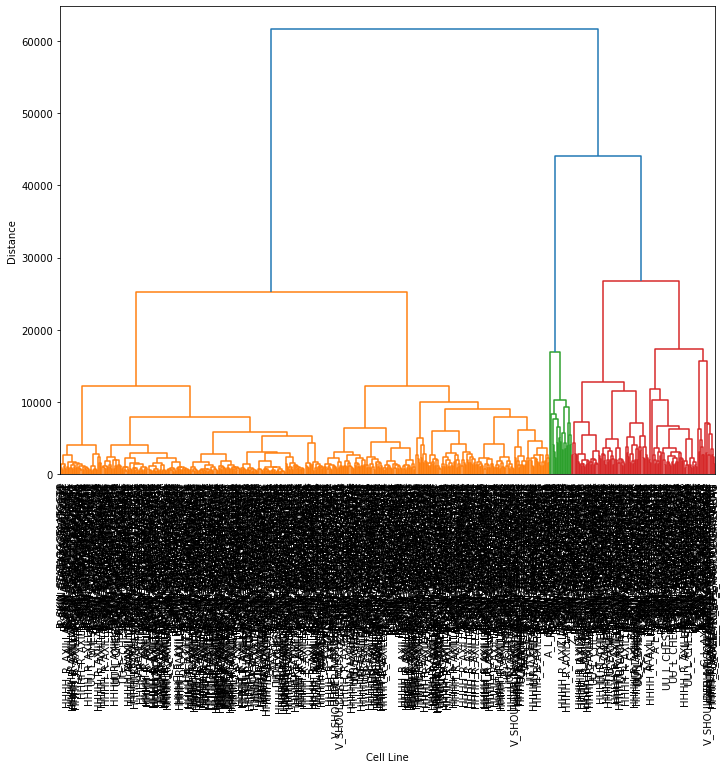

In [19]:

dendrogrammer(df, cells)

In [5]:
def PCAer(df):
     print(df.values)
     D = df.values
     D = np.transpose(D)
     pca = PCA(n_components= 50)
     pca.fit(D)
     projected = pca.fit_transform(D)
     return projected

In [6]:
from sklearn.cluster import KMeans
Dpc = PCAer(df)
kmeans = KMeans(n_clusters=3)
kmeans = kmeans.fit(Dpc)
print(Dpc)
print(kmeans)
labels = kmeans.predict(Dpc)
C = kmeans.cluster_centers_
out = [Dpc, labels, C]
[proj, labels, centroids] = out
true_coords = {}
true_cells = {}
true_labels = {}
for i in range(len(Dpc)):
    coords = str(proj[i:i+1,0]) + " " + str(proj[i+1:i+2,1]) + " " + str(proj[ i+2:i+3,2])
    print(coords)
    true_cells.update({str(coords).strip():labels[i]})
    true_labels.update({cells[i]:labels[i]})
    true_coords.update({cells[i]:str(coords).strip()})
print(true_coords)
print(true_cells)
'''
def kmeanser(df, k): 
    Dpc = PCAer(df)
    kmeans = KMeans(n_clusters=3)
    kmeans = kmeans.fit(Dpc)
    labels = kmeans.predict(Dpc)
    C = kmeans.cluster_centers_
    out = [Dpc, labels, C]
    print(np.bincount(kmeans.labels_))
    return out
'''
def ClusterIndicesNumpy(clustNum, labels_array): #numpy 
    return np.where(labels_array == clustNum)[0]

def ClusterIndicesComp(clustNum, labels_array): #list comprehension
    return np.array([i for i, x in enumerate(labels_array) if x == clustNum])

[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [159 215 200 ... 176 185   0]
 [  0   3   2 ...   2   2   0]
 [377 722 855 ... 525 151   1]]
[[ -703.68924358 -1010.61014148   130.83626952 ...   -18.92593507
    -18.58270954   -70.25940561]
 [  398.47282274   862.35697391  -458.7283149  ...   -25.75603281
    -58.53068196   -33.63372389]
 [ 1485.37917175   503.05158759  -881.79335916 ...   -54.58480368
     43.5588814    -71.93861966]
 ...
 [  429.27632876  -315.70123919  -459.01866926 ...   -26.00405088
     -6.66407815   -16.96278156]
 [-1690.38196269  -697.25991904   -84.3303534  ...   -17.8138677
     -6.57580196    20.55128315]
 [-2851.13231245  -950.39069922   227.29107016 ...   -42.99325095
    -33.49023021   -15.99306713]]
KMeans(n_clusters=3)
[-703.68924358] [862.35697391] [-881.79335916]
[398.47282274] [503.05158759] [-1082.00211885]
[1485.37917175] [246.99246747] [-674.68192667]
[3129.24933374] [-219.83983542] [-351.37245189]

[459.19940354] [939.62650914] [-181.64324255]
[-477.39379425] [288.1067167] [378.77382143]
[-1642.65928613] [-365.29845034] [-611.53286476]
[976.48314138] [-27.06590213] [-1217.20873849]
[1273.44374923] [2008.30861204] [-191.77552606]
[-206.37832096] [976.64580715] [-326.23239278]
[-1513.91538573] [202.60412065] [1334.51236239]
[-1511.19369697] [-296.57092088] [-1133.34861466]
[-1407.46382911] [-1091.70689454] [-891.10951034]
[2974.22213527] [618.32286598] [354.37808033]
[-434.69826041] [922.84330566] [1116.56218414]
[-1608.33285208] [472.35654916] [-917.68537811]
[-399.67546033] [3100.48238972] [-182.45742762]
[-830.28962548] [757.94700532] [-529.64372417]
[-1843.52793298] [53.61464979] [-12.41896507]
[-730.1203632] [-160.68944165] [43.68981739]
[-2326.95614498] [2660.30363004] [-61.67064423]
[521.61135898] [1485.50732967] [837.98476001]
[-1192.78577876] [576.89818085] [6884.27456936]
[-996.14643112] [1.09039752] [1560.23441057]
[671.82974567] [-1130.10168115] [-217.81100204]
[222.976

In [9]:
import json
def DataCollection(algorithm, cluster_1, cluster_2, cluster_3, results):
    
    labels = true_labels
    
    num1 = []
    num2 = []
    num3 = []
    
#     num1 = ClusterIndicesNumpy(0, algorithm.labels_)
#     num2 = ClusterIndicesNumpy(1, algorithm.labels_)
#     num3 = ClusterIndicesNumpy(2, algorithm.labels_) 
    barcodes1 = {}
    barcodes2 = {}
    barcodes3 = {}
    truthnum1 = {}
    for i in labels:
        if labels[i] == 0:
            barcodes1.update({i:labels[i]})
        elif labels[i] == 1:
            barcodes2.update({i:labels[i]})
        else:
            barcodes3.update({i:labels[i]})
        
#     for i in num1:
#         barcodes1.update({cells[i]:i})
#     for i in num2:
#         barcodes2.update({cells[i]:i})
#     for i in num3:
#         barcodes3.update({cells[i]:i})
    with open(cluster_1, 'w') as filehandle:
        for listitem in barcodes1:
            filehandle.write('%s\n' % listitem)
    with open(cluster_2, 'w') as filehandle:
        for listitem in barcodes2:
            filehandle.write('%s\n' % listitem)
    with open(cluster_3, 'w') as filehandle:
        for listitem in barcodes3:
            filehandle.write('%s\n' % listitem)
        
        
    g1 = open('G1Cells.txt').readlines()
    g1_line = []
    for lines in g1:
        g1_line.append(lines)
    g2m = open('G2MCells.txt').readlines()
    g2m_line = []
    for lines in g2m:
        g2m_line.append(lines)
    s = open('SCells.txt').readlines()
    s_line = []

    res = open(results, "w")

    g1count = 0
    g2mcount = 0
    scount = 0

    g1count2 = 0
    g2mcount2 = 0
    scount2 = 0

    g1count3 = 0
    g2mcount3 = 0
    scount3 = 0
    
    x = 0
    y = 0
    z = 0

    for lines in s:
        s_line.append(lines)
    cluster1 = open(cluster_1).readlines()
    cluster1_line = []
    for lines in cluster1:
        cluster1_line.append(lines)
    for i in cluster1_line:
        for j in g1_line:
            if i == j:
                g1count = g1count + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'red'})
                #DataCollection.truthnum1.update({(barcodes1[i]):'black'})
    res.write("G1 Count Cluster 1: \n")
    res.write(str(g1count/(len(cluster1_line))) + " \n")
    res.write(str(g1count) + " \n")
    for x in cluster1_line:
        for y in g2m_line:
            if x == y:
                g2mcount = g2mcount + 1
                truthnum1.update({true_coords[x[0:len(x)-1]]:'black'})
                #DataCollection.truthnum1.update({(barcodes1[i]):'red'})
    res.write("G2M Count Cluster 1: \n")
    res.write(str(g2mcount/(len(cluster1_line))) + "\n")
    res.write(str(g2mcount) + "\n")
    for i in cluster1_line:
        for j in s_line:
            if i == j:
                scount = scount + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'red'})
                #DataCollection.truthnum1.update({(barcodes1[i]):'red'})
    res.write("S Count Cluster 1: \n")
    res.write(str(scount/(len(cluster1_line))) + "\n")
    res.write(str(scount) + "\n")
    res.write("\n")

    cluster2 = open(cluster_2).readlines()
    cluster2_line = []
    for lines in cluster2:
        cluster2_line.append(lines)
    for i in cluster2_line:
        for j in g1_line:
            if i == j:
                g1count2 = g1count2 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'black'})
                #DataCollection.truthnum1.update({(barcodes2[i]):'red'})
    res.write("G1 Count Cluster 2:" + "\n")
    res.write(str(g1count2/(len(cluster2_line))) + "\n")
    res.write(str(g1count2) + "\n")
    for i in cluster2_line:
        for j in g2m_line:
            if i == j:
                g2mcount2 = g2mcount2 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'red'})
                #DataCollection.truthnum1.update({(barcodes2[i]):'black'})
    res.write("G2M Count Cluster 2:" + "\n")
    res.write(str(g2mcount2/(len(cluster2_line))) + "\n")
    res.write(str(g2mcount2) + "\n")
    for i in cluster2_line:
        for j in s_line:
            if i == j:
                scount2 = scount2 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'red'})
                #DataCollection.truthnum1.update({(barcodes2[i]):'red'})
    res.write("S Count Cluster 2: \n")
    res.write(str(scount2/(len(cluster2_line))) + "\n")
    res.write(str(scount2) + "\n")
    res.write("\n")

    cluster3 = open(cluster_3).readlines()
    cluster3_line = []
    for lines in cluster3:
        cluster3_line.append(lines)
    for i in cluster3_line:
        for j in g1_line:
            if i == j:
                g1count3 = g1count3 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'red'})
                #DataCollection.truthnum1.update({(barcodes3[i]):'red'})
    res.write("G1 Count Cluster 3:" + "\n")
    res.write(str(g1count3/(len(cluster3_line))) + "\n")
    res.write(str(g1count3) + "\n")
    for i in cluster3_line:
        for j in g2m_line:
            if i == j:
                g2mcount3 = g2mcount3 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'red'})
                #DataCollection.truthnum1.update({(barcodes3[i]):'red'})
    res.write("G2M Count Cluster 3:" + "\n")
    res.write(str(g2mcount3/(len(cluster3_line))) + "\n")
    res.write(str(g2mcount3) + "\n")
    for i in cluster3_line:
        for j in s_line:
            if i == j:
                scount3 = scount3 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'black'})
                #DataCollection.truthnum1.update({(barcodes3[i]):'black'})
    res.write("S Count Cluster 3:" + "\n")
    res.write(str(scount3/(len(cluster3_line))) + "\n")
    res.write(str(scount3) + "\n")
    res.write("\n")
    res.write(json.dumps(truthnum1))
    res.write("")
    print(len(truthnum1))
    return truthnum1
DataCollection(kmeans, 'kmeans_cluster1.txt', 'kmeans_cluster2.txt', 'kmeans_cluster3.txt', 'kmeans_results.txt')

623


{'[5218.79726969] [-859.24032885] [-119.66327121]': 'red',
 '[5648.28569852] [118.71259713] [241.04810863]': 'red',
 '[5529.42063191] [-116.14406713] [-160.81865065]': 'red',
 '[6836.35783863] [-651.08896003] [-197.70058482]': 'black',
 '[9595.79779531] [1385.15326712] [-766.79602851]': 'black',
 '[7085.13732988] [-1152.93898971] [241.84843165]': 'black',
 '[5629.54722377] [1453.13188991] [276.82044068]': 'black',
 '[7688.43193974] [1000.21759256] [-43.29757316]': 'black',
 '[8918.56155108] [1525.56258133] [-588.73189789]': 'black',
 '[5876.83011917] [-807.07803468] [195.34319476]': 'black',
 '[8984.89244093] [-786.94269517] [-533.08517655]': 'black',
 '[4885.78958379] [574.45240887] [-696.43941439]': 'black',
 '[9459.8920726] [-1188.62553025] [875.44649316]': 'black',
 '[12517.34899274] [320.09794838] [608.27882649]': 'black',
 '[6412.1012233] [-1638.98581021] [173.29255961]': 'black',
 '[6443.19405041] [-625.29395424] [1689.82461005]': 'black',
 '[7987.53891329] [-542.34489974] [3.76

623


KeyError: '[-1962.64761619] [-967.73530491] [-459.01866926]'

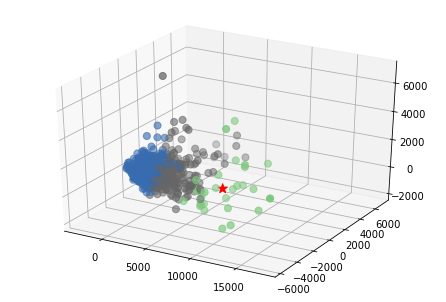

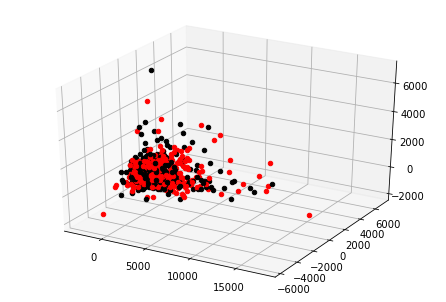

In [10]:
from mpl_toolkits.mplot3d import Axes3D
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1 = Axes3D(fig1)
[proj, labels, centroids] = out
ax1.scatter(proj[:,0], proj[:, 1], proj[:, 2], c=labels, s=50, cmap='Accent')

colors = DataCollection(kmeans, 'kmeans_cluster1.txt', 'kmeans_cluster2.txt', 'kmeans_cluster3.txt', 'kmeans_results.txt')
ax1.scatter(centroids[:,0], centroids[:, 1], centroids[:,2], c = 'red', s=100, marker='*', cmap='Accent')
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2 = Axes3D(fig2)
for i in range(len(proj)):
    coords = str(proj[i:i+1,0]) + " " + str(proj[i+1:i+2,1]) + " " + str(proj[ i+2:i+3,2])
    ax2.scatter(proj[i:i+1, 0], proj[i+1:i+2, 1], proj[i+2:i+3, 2], c=colors[coords])


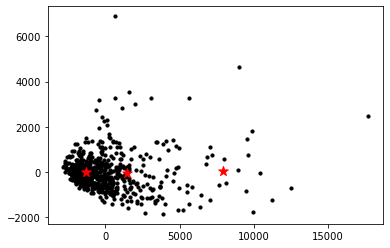

In [63]:
plt.scatter(proj[:,0], proj[:,2], s=10.0, color='black')
plt.scatter(centroids[:,0], centroids[:, 2], c = 'red', s = 100, marker='*', cmap='Accent')

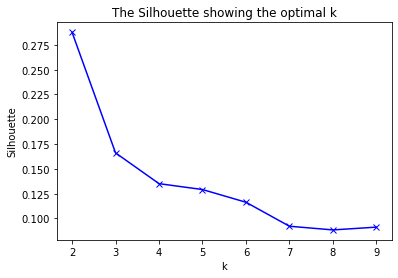

In [18]:
from sklearn.metrics import silhouette_score
K = range(2, 10)
sil = []
Dpc = PCAer(df)
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans = kmeans.fit(Dpc)
    labels = kmeans.predict(Dpc)
    sil.append(silhouette_score(Dpc, labels))
plt.plot(K, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette')
plt.title('The Silhouette showing the optimal k')
plt.show()

In [381]:
from scipy.spatial.distance import cdist
distortions = []
K = range(1, 10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(df)
    kmeanModel.fit(df)
    #distortions.append(sum(np.min(cdist(df, kmeanModel.cluster_centers_, 'euclidean'), axis = 1))/df.shape[0])
    distortions.append(kmeanModel.inertia_)
print(distortions)

[4261452.850400253, 2609587.3986792946, 2072151.2291102142, 1842446.972326549, 1727576.3063238966, 1674567.6291417652, 1638910.5319379584, 1612116.3121806663, 1595880.7312405473]


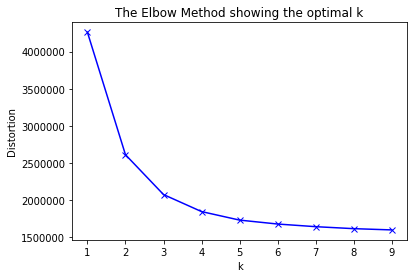

In [380]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()